In [3]:
# from google.colab import drive
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, confusion_matrix

In [4]:
# # Mount Google Drive
# drive.mount('/content/drive')

# # File path
# file_path = "/content/drive/MyDrive/Wake County 780 Dataset.csv"

# # Load the dataset
# HDMA = pd.read_csv(file_path)

# # Display basic information
# # print(df.info())


url = "https://drive.usercontent.google.com/u/0/uc?id=1pDqazBinw3E3-1OyqzfACq5SrBqwYs_4&export=download"

HDMA = pd.read_csv(url)
HDMA.head()



/var/folders/2c/syyg1pks1tn35zqcqdf1629m0000gn/T/ipykernel_11458/1571081314.py:16: DtypeWarning: Columns (22,23,24,26,27,28,29,30,31,32,33,38,43,44) have mixed types. Specify dtype option on import or set low_memory=False.
  HDMA = pd.read_csv(url)


,activity_year,lei,derived_msa-md,state_code,county_code,census_tract,conforming_loan_limit,derived_loan_product_type,derived_dwelling_category,derived_ethnicity,...,denial_reason-2,denial_reason-3,denial_reason-4,tract_population,tract_minority_population_percent,ffiec_msa_md_median_family_income,tract_to_msa_income_percentage,tract_owner_occupied_units,tract_one_to_four_family_homes,tract_median_age_of_housing_units
0,2022,549300FGXN1K3HLB1R50,39580,NC,37183,3.718305e+10,C,Conventional:First Lien,Single Family (1-4 Units):Site-Built,Ethnicity Not Available,...,NaN,NaN,NaN,10600,27.27,110100,144.56,2355,2695,16
1,2022,549300FGXN1K3HLB1R50,39580,NC,37183,3.718305e+10,C,Conventional:First Lien,Single Family (1-4 Units):Site-Built,Not Hispanic or Latino,...,NaN,NaN,NaN,6300,72.98,110100,83.71,1386,1917,19
2,2022,549300FGXN1K3HLB1R50,39580,NC,37183,3.718305e+10,C,Conventional:First Lien,Single Family (1-4 Units):Site-Built,Not Hispanic or Latino,...,NaN,NaN,NaN,6300,72.98,110100,83.71,1386,1917,19
3,2022,549300FGXN1K3HLB1R50,39580,NC,37183,3.718305e+10,C,Conventional:Subordinate Lien,Single Family (1-4 Units):Site-Built,Hispanic or Latino,...,NaN,NaN,NaN,7613,62.12,110100,91.54,2041,2513,18
4,2022,549300FGXN1K3HLB1R50,39580,NC,37183,3.718305e+10,C,FHA:First Lien,Single Family (1-4 Units):Site-Built,Ethnicity Not Available,...,NaN,NaN,NaN,7746,74.35,110100,145.04,1981,2500,9


#### **These are all the variables we thought could provide some useful information.**
*We can eventually delete the next code.*

In [5]:
selected_columns = [
    # Bias Analysis
    'derived_race', 'derived_ethnicity', 'derived_sex', 'applicant_age', 'income', 'debt_to_income_ratio',
    'applicant_race-1', 'co-applicant_race-1', 'applicant_ethnicity-1', 'co-applicant_ethnicity-1',

    # Loan-Specific Variables
    'loan_amount', 'interest_rate', 'loan_to_value_ratio', 'loan_type', 'loan_purpose', 'lien_status',

    # Geographic Variable
    'census_tract',

    # Loan Decision Variables
    'action_taken', 'purchaser_type', 'preapproval', 'aus-1', 'denial_reason-1',

    # Bias & Fairness Analysis
    'rate_spread', 'hoepa_status', 'negative_amortization', 'interest_only_payment', 'balloon_payment',

    # Lender Bias
    'lei', 'conforming_loan_limit', 'derived_loan_product_type', 'derived_dwelling_category'
]
# Filter dataset
missing_value_check = HDMA[selected_columns]

# Display summary of the cleaned dataset
print(missing_value_check.info())
missing_value_check.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76111 entries, 0 to 76110
Data columns (total 31 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   derived_race               76111 non-null  object 
 1   derived_ethnicity          76111 non-null  object 
 2   derived_sex                76111 non-null  object 
 3   applicant_age              76111 non-null  object 
 4   income                     70594 non-null  float64
 5   debt_to_income_ratio       53332 non-null  object 
 6   applicant_race-1           76102 non-null  float64
 7   co-applicant_race-1        76109 non-null  float64
 8   applicant_ethnicity-1      76080 non-null  float64
 9   co-applicant_ethnicity-1   76103 non-null  float64
 10  loan_amount                76111 non-null  float64
 11  interest_rate              51174 non-null  object 
 12  loan_to_value_ratio        53005 non-null  object 
 13  loan_type                  76111 non-null  int

,derived_race,derived_ethnicity,derived_sex,applicant_age,income,debt_to_income_ratio,applicant_race-1,co-applicant_race-1,applicant_ethnicity-1,co-applicant_ethnicity-1,...,denial_reason-1,rate_spread,hoepa_status,negative_amortization,interest_only_payment,balloon_payment,lei,conforming_loan_limit,derived_loan_product_type,derived_dwelling_category
0,Race Not Available,Ethnicity Not Available,Sex Not Available,35-44,81.0,49,6.0,8.0,3.0,5.0,...,10,0.977,2,2,2,2,549300FGXN1K3HLB1R50,C,Conventional:First Lien,Single Family (1-4 Units):Site-Built
1,Black or African American,Not Hispanic or Latino,Female,45-54,94.0,40,3.0,8.0,2.0,5.0,...,10,0.463,2,2,2,2,549300FGXN1K3HLB1R50,C,Conventional:First Lien,Single Family (1-4 Units):Site-Built
2,Asian,Not Hispanic or Latino,Joint,25-34,204.0,<20%,2.0,2.0,2.0,2.0,...,10,-0.18,2,2,2,2,549300FGXN1K3HLB1R50,C,Conventional:First Lien,Single Family (1-4 Units):Site-Built
3,White,Hispanic or Latino,Male,45-54,195.0,<20%,5.0,8.0,1.0,5.0,...,10,4.392,2,2,2,2,549300FGXN1K3HLB1R50,C,Conventional:Subordinate Lien,Single Family (1-4 Units):Site-Built
4,Race Not Available,Ethnicity Not Available,Sex Not Available,25-34,109.0,<20%,6.0,8.0,3.0,5.0,...,10,0.181,2,2,2,2,549300FGXN1K3HLB1R50,C,FHA:First Lien,Single Family (1-4 Units):Site-Built


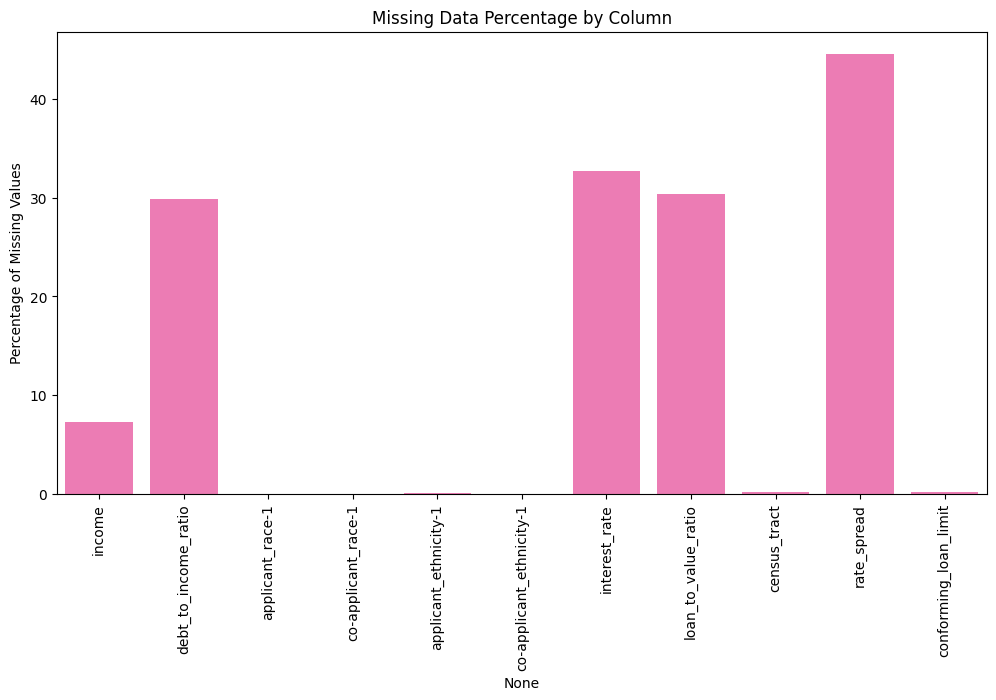

rate_spread                 44.605905
interest_rate               32.763989
loan_to_value_ratio         30.358292
debt_to_income_ratio        29.928657
income                       7.248624
conforming_loan_limit        0.193139
census_tract                 0.141898
applicant_ethnicity-1        0.040730
applicant_race-1             0.011825
co-applicant_ethnicity-1     0.010511
co-applicant_race-1          0.002628
dtype: float64


In [6]:
# Calculate missing values percentage for selected columns
missing_percentages = missing_value_check.isnull().mean() * 100

# Filter columns with missing values
missing_percentages = missing_percentages[missing_percentages > 0]

# Plot missing values
plt.figure(figsize=(12, 6))
sns.barplot(x=missing_percentages.index, y=missing_percentages.values, color="hotpink")
plt.xticks(rotation=90)
plt.ylabel("Percentage of Missing Values")
plt.title("Missing Data Percentage by Column")

# Show plot
plt.show()

# Display missing values in descending order
missing_percentages = missing_percentages.sort_values(ascending=False)

# Show the results
print(missing_percentages)

**There are too many missing values, so we have to clean the dataset**

# **Data Cleaning**

## **Drop Columns with >95% Missing Data.**
**Since there are a lot of missing values, we;**
1. Drop columns with 100% missing values.
2. Drop columns with more than 95% missing value.
3. Keep only the relevant columns necessary for our bias detection and fairness analysis.

In [7]:
# Drop Columns with High Missing Values

# Define columns to drop (100% missing and >95% missing)
columns_to_drop = [
    # 100% missing
    'applicant_ethnicity-4', 'applicant_ethnicity-5', 'co-applicant_ethnicity-5',
    'co-applicant_ethnicity-4', 'co-applicant_race-5', 'applicant_race-5',

    # >95% missing
    'co-applicant_race-4', 'co-applicant_ethnicity-3', 'denial_reason-4', 'applicant_race-4',
    'applicant_ethnicity-3', 'co-applicant_race-3', 'denial_reason-3', 'multifamily_affordable_units',
    'applicant_race-3', 'total_points_and_fees', 'aus-5', 'co-applicant_ethnicity-2', 'aus-4',
    'aus-3', 'aus-2', 'denial_reason-2', 'applicant_ethnicity-2', 'co-applicant_race-2', 'prepayment_penalty_term'
]

# Drop the identified columns (errors='ignore' ensures no error if a column is already missing)
HDMA = HDMA.drop(columns=columns_to_drop, errors='ignore')

print(f"✅Dropped {len(columns_to_drop)} columns with excessive missing data.")


✅Dropped 25 columns with excessive missing data.


## **Impute Key Loan/Financial Features (50-95% Missing).**

Certain loan and financial variables have a high percentage of missing values but are essential for creditworthiness assessment and loan approval decisions. Rather than removing these variables, an imputation strategy will be applied based on the nature of each variable.

| **Column**                     | **Missing %** | **Imputation Strategy**  |
|--------------------------------|--------------|--------------------------|
| lender_credits                 | 83.89%       | Fill with **"Unknown"** (to preserve missingness and avoid bias) |
| discount_points                | 77.90%       | Fill with **"Unknown"** (to preserve missingness and avoid bias) |
| intro_rate_period              | 69.82%       | Fill with **median** |
| co-applicant_age_above_62      | 63.60%       | Fill with **"Unknown"** (to preserve missingness and avoid bias) |
| total_loan_costs               | 53.95%       | Fill with **median** |
| origination_charges            | 53.70%       | Fill with **median** |

This imputation approach ensures that critical financial information is retained while minimizing bias in the dataset.


#### **Imputing Missing Values in co-applicant_age_above_62**

The variable *co-applicant_age_above_62* has a significant proportion of missing values. Among the known values, 85.73% are classified as "No," while 14.27% are classified as "Yes." **A mode-based imputation strategy would suggest filling missing values with "No," as it represents the majority.** However, this approach assumes that the distribution of missing values follows the observed data, which may introduce unintended bias by underrepresenting older co-applicants.

To ensure fairness and avoid reinforcing potential biases, the missing values will be imputed with **"Unknown.**"


In [8]:
print(HDMA["co-applicant_age_above_62"].value_counts(normalize=True) * 100)

co-applicant_age_above_62
No     85.729757
Yes    14.270243
Name: proportion, dtype: float64


In [9]:
# Convert numerical columns to proper numeric format
numeric_columns = ['intro_rate_period', 'total_loan_costs', 'origination_charges']
HDMA[numeric_columns] = HDMA[numeric_columns].apply(pd.to_numeric, errors='coerce')

# Impute missing values correctly
HDMA = HDMA.assign(
    lender_credits=HDMA['lender_credits'].fillna("Unknown"),
    discount_points=HDMA['discount_points'].fillna("Unknown"),
    co_applicant_age_above_62=HDMA['co-applicant_age_above_62'].fillna("Unknown"),
    intro_rate_period=HDMA['intro_rate_period'].fillna(HDMA['intro_rate_period'].median()),
    total_loan_costs=HDMA['total_loan_costs'].fillna(HDMA['total_loan_costs'].median()),
    origination_charges=HDMA['origination_charges'].fillna(HDMA['origination_charges'].median())
)

# assignment for `applicant_race-2`
HDMA['applicant_race-2'] = HDMA['applicant_race-2'].fillna("Not Provided")

## **Impute Important Features with Limited Missing Data (<50%).**

### Variables to Impute (Analysis of Each Feature)

| **Column**                    | **Missing %** | **Suggested Imputation Strategy** | **Justification** |
|--------------------------------|--------------|----------------------------------|-------------------|
| rate_spread                   | 44.60%       | Fill with median                 | The median ensures outliers don’t skew results, maintaining fairness. |
| interest_rate                 | 32.76%       | Fill with median                 | Interest rates follow a distribution, and the median is robust against extreme values. |
| loan_to_value_ratio           | 30.35%       | Fill with median                 | This is a continuous numerical feature—median prevents extreme distortions. |
| debt_to_income_ratio          | 29.92%       | Fill with median                 | Critical creditworthiness metric—median keeps values realistic. |
| property_value                | 21.56%       | Fill with median                 | Property values can vary widely, so the median is a better estimator than the mean. |
| applicant_age_above_62        | 7.54%        | Fill with "Unknown"              | Age is a demographic factor; keeping "Unknown" preserves missingness and avoids bias. |
| income                        | 7.24%        | Fill with median                 | Income distribution often skews high; the median minimizes the impact of extreme values. |
| loan_term                     | 7.18%        | Fill with median                 | Loan terms are standard (e.g., 15, 30 years); median maintains structure. |
| conforming_loan_limit         | 0.19%        | Fill with mode                   | A categorical variable—most loans fall under a common classification. |
| census_tract                  | 0.14%        | Fill with mode                   | Geographic area information—most properties will belong to the most common tract. |
| applicant_ethnicity-1         | 0.04%        | Fill with mode                   | Ethnicity is categorical—mode reflects the most common group without introducing new bias. |
| applicant_race-1              | 0.01%        | Fill with mode                   | Race is categorical—mode ensures consistency in demographic representation. |
| co-applicant_ethnicity-1      | 0.01%        | Fill with mode                   | Mode maintains coherence across cases with co-applicants. |
| co-applicant_race-1           | 0.002%       | Fill with mode                   | Mode ensures demographic completeness without artificial adjustments. |


In [10]:
# Convert numerical columns to proper numeric format before imputing
numeric_cols = [
    'rate_spread', 'interest_rate', 'loan_to_value_ratio', 'debt_to_income_ratio',
    'property_value', 'income', 'loan_term'
]
HDMA[numeric_cols] = HDMA[numeric_cols].apply(pd.to_numeric, errors='coerce')

# Impute numerical variables with median
HDMA[numeric_cols] = HDMA[numeric_cols].apply(lambda col: col.fillna(col.median()))

# Impute categorical variables with mode
categorical_cols = [
    'conforming_loan_limit', 'census_tract', 'applicant_ethnicity-1',
    'applicant_race-1', 'co-applicant_ethnicity-1', 'co-applicant_race-1'
]
HDMA[categorical_cols] = HDMA[categorical_cols].apply(lambda col: col.fillna(col.mode()[0]))

# Impute applicant_age_above_62 with "Unknown" to preserve missingness and avoid bias
HDMA['co-applicant_age_above_62'] = HDMA['co-applicant_age_above_62'].fillna("Unknown")

In [11]:
HDMA.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76111 entries, 0 to 76110
Data columns (total 75 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   activity_year                             76111 non-null  int64  
 1   lei                                       76111 non-null  object 
 2   derived_msa-md                            76111 non-null  int64  
 3   state_code                                76111 non-null  object 
 4   county_code                               76111 non-null  int64  
 5   census_tract                              76111 non-null  float64
 6   conforming_loan_limit                     76111 non-null  object 
 7   derived_loan_product_type                 76111 non-null  object 
 8   derived_dwelling_category                 76111 non-null  object 
 9   derived_ethnicity                         76111 non-null  object 
 10  derived_race                      

# **Dataset Name**
**The original dataset name is HDMA, but this still has 74 columns which we do not all need. The HDMA dataset is the one I cleaned but for the purpose of this project, the code below will filter the columns we need.**
- The name of the dataset which has the variables we need is **HDMA_filtered.**

In [12]:
# Define selected columns for final dataset
selected_columns = [
    # Bias Analysis
    'derived_race', 'derived_ethnicity', 'derived_sex', 'applicant_age', 'income', 'debt_to_income_ratio',
    'applicant_race-1', 'co-applicant_race-1', 'applicant_ethnicity-1', 'co-applicant_ethnicity-1',

    # Loan-Specific Variables
    'loan_amount', 'interest_rate', 'loan_to_value_ratio', 'loan_type', 'loan_purpose', 'lien_status',

    # Geographic Variable
    'census_tract',

    # Loan Decision Variables
    'action_taken', 'purchaser_type', 'preapproval', 'aus-1', 'denial_reason-1',

    # Bias & Fairness Analysis
    'rate_spread', 'hoepa_status', 'negative_amortization', 'interest_only_payment', 'balloon_payment',

    # Lender Bias
    'lei', 'conforming_loan_limit', 'derived_loan_product_type', 'derived_dwelling_category'
]
# Filter dataset to keep only required columns
HDMA_filtered = HDMA[selected_columns]

# Display summary of the final cleaned dataset
print(f"Final dataset contains {len(HDMA_filtered.columns)} columns and {HDMA_filtered.shape[0]} rows.")
print(HDMA_filtered.info())

# Show first few rows
# HDMA_filtered.head()

Final dataset contains 31 columns and 76111 rows.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76111 entries, 0 to 76110
Data columns (total 31 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   derived_race               76111 non-null  object 
 1   derived_ethnicity          76111 non-null  object 
 2   derived_sex                76111 non-null  object 
 3   applicant_age              76111 non-null  object 
 4   income                     76111 non-null  float64
 5   debt_to_income_ratio       76111 non-null  float64
 6   applicant_race-1           76111 non-null  float64
 7   co-applicant_race-1        76111 non-null  float64
 8   applicant_ethnicity-1      76111 non-null  float64
 9   co-applicant_ethnicity-1   76111 non-null  float64
 10  loan_amount                76111 non-null  float64
 11  interest_rate              76111 non-null  float64
 12  loan_to_value_ratio        76111 non-null  float64
 

# **EDA**

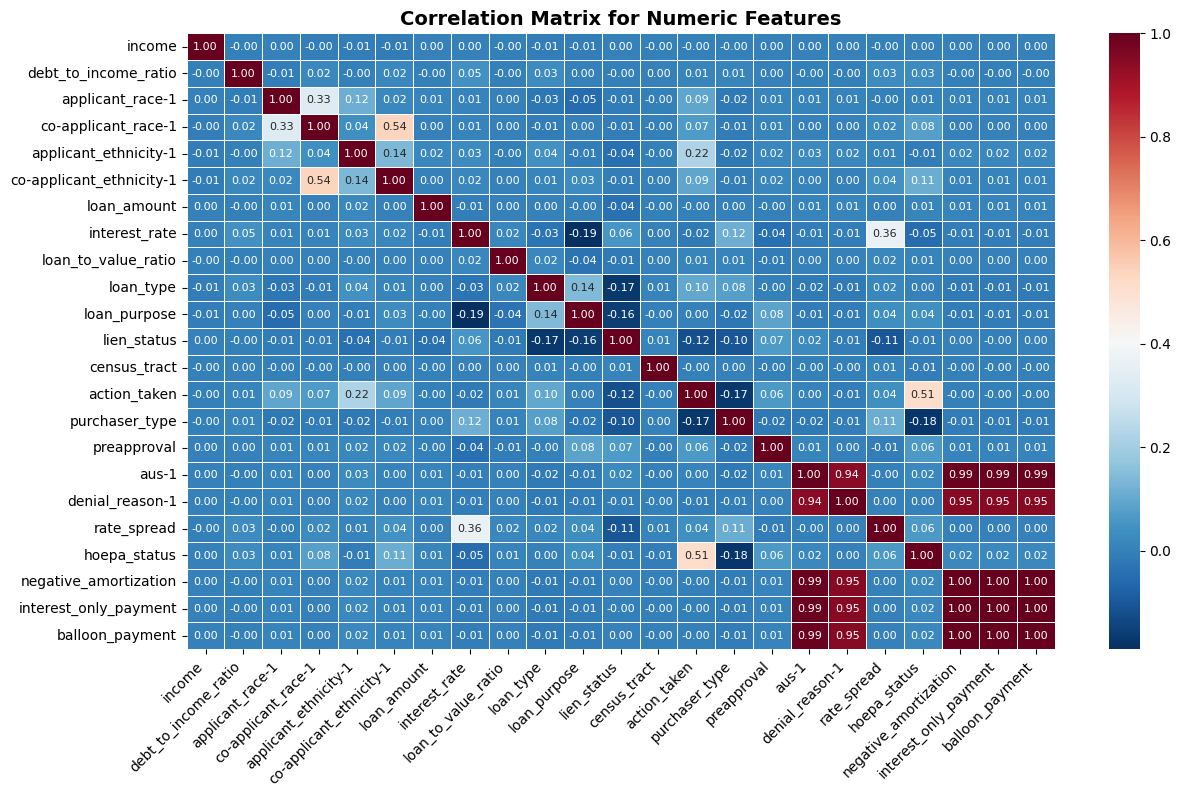

In [13]:
# Select only numeric columns from HDMA_filtered
HDMA_numeric = HDMA_filtered.select_dtypes(include=['number'])

# Set figure size for better readability
plt.figure(figsize=(14, 8))

# Generate heatmap with improved styling
sns.heatmap(
    HDMA_numeric.corr(),
    annot=True,
    cmap="RdBu_r",  # Alternative: "coolwarm", "viridis", "Blues"
    fmt=".2f",
    linewidths=0.7,
    annot_kws={"size": 8}  # Adjust annotation font size
)

# Improve axis labels
plt.xticks(rotation=45, ha="right", fontsize=10)  # Rotate for readability
plt.yticks(fontsize=10)
plt.title("Correlation Matrix for Numeric Features", fontsize=14, fontweight="bold")

plt.show()


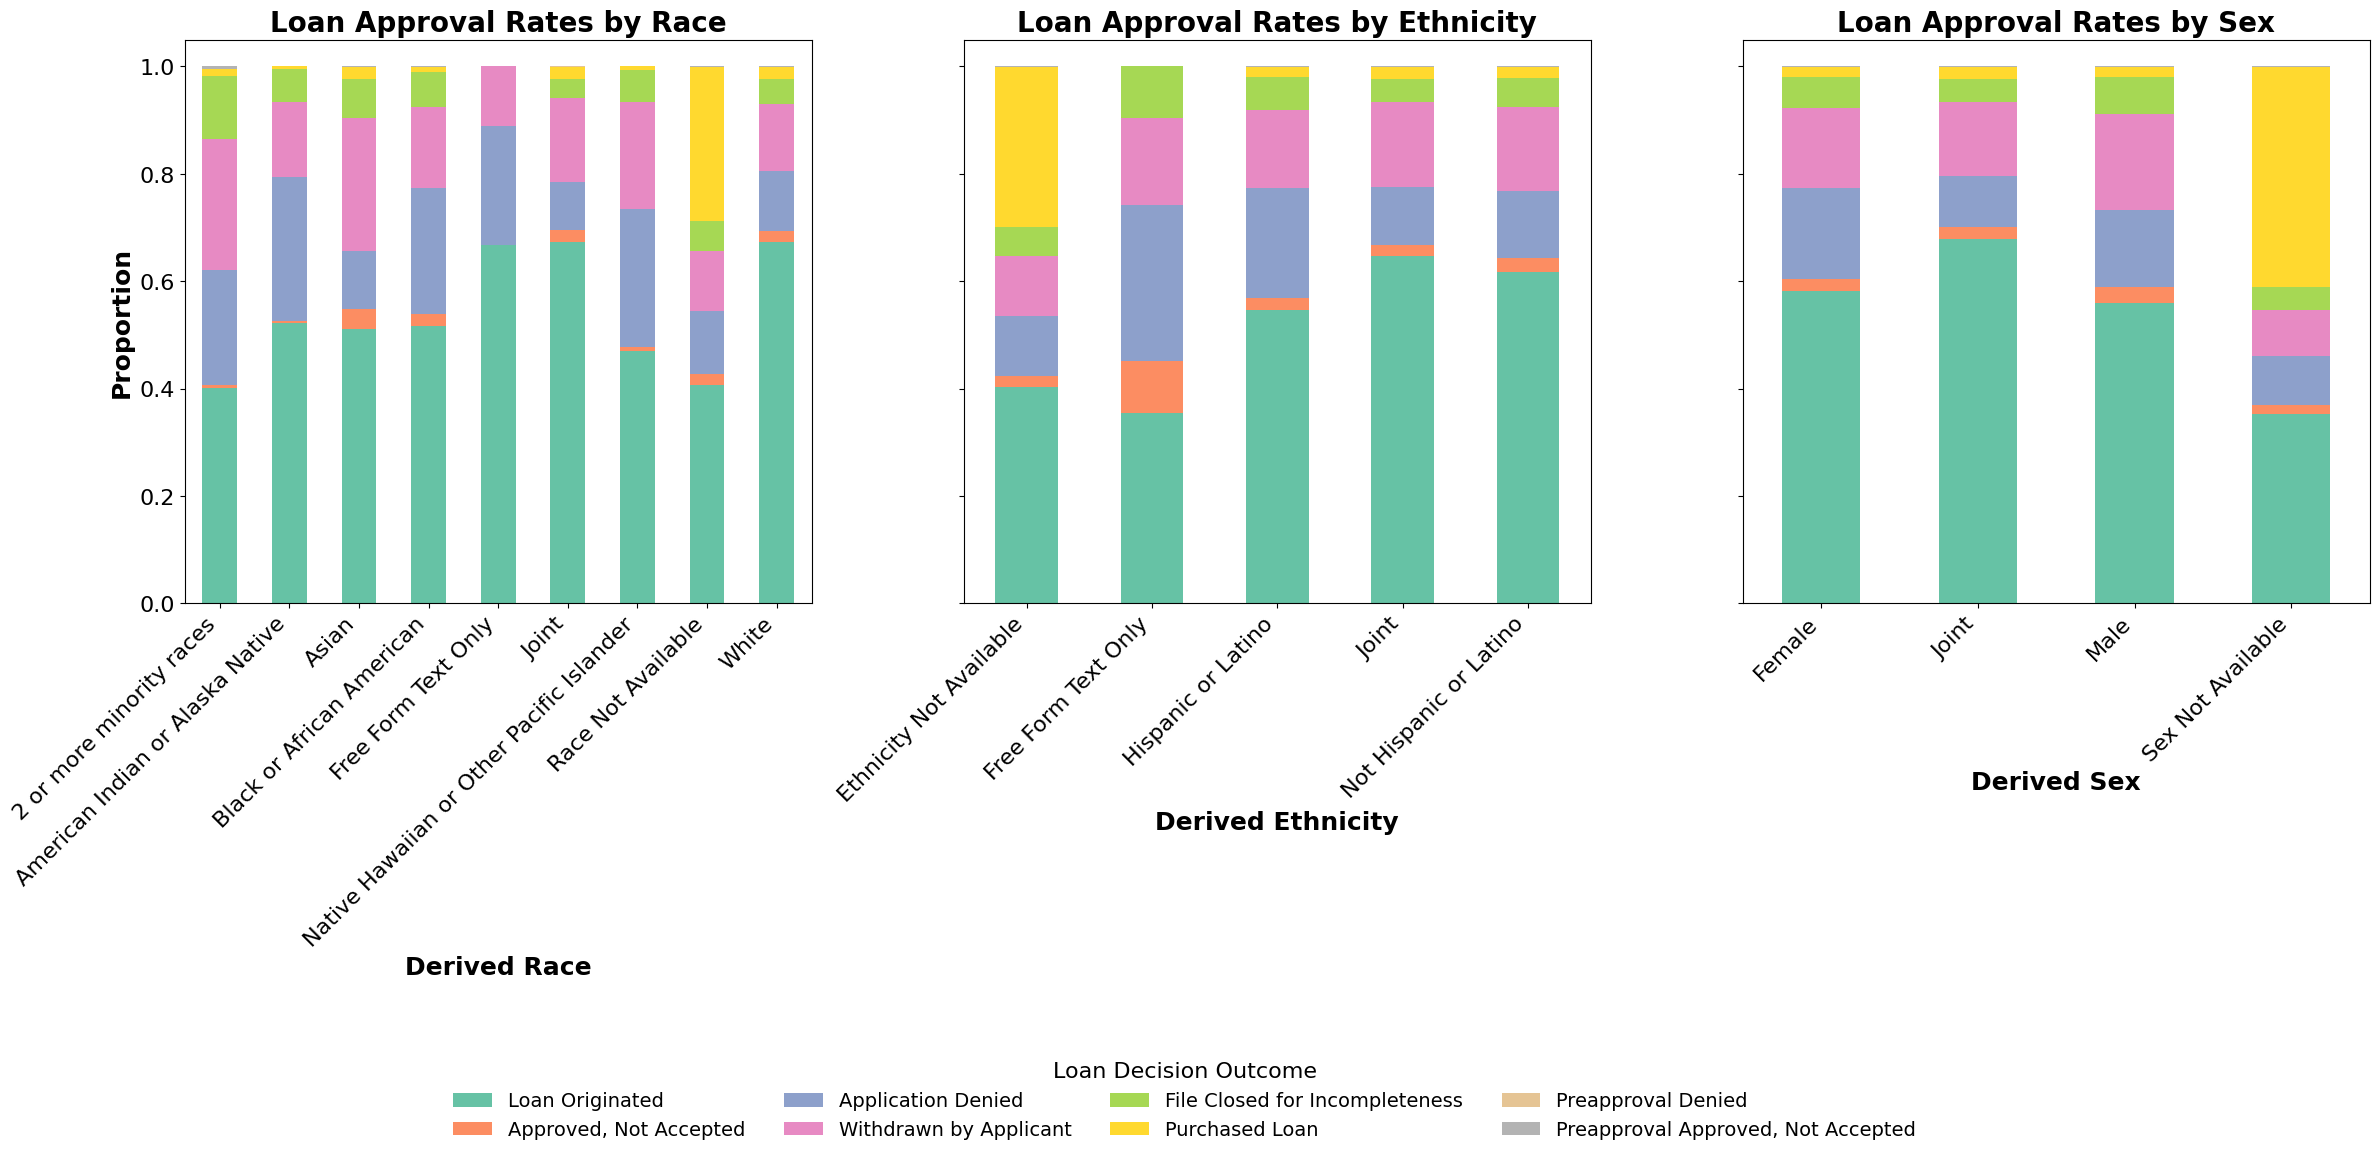

In [14]:
# Define the mapping of action_taken values to meaningful labels
action_labels = {
    1: "Loan Originated",
    2: "Approved, Not Accepted",
    3: "Application Denied",
    4: "Withdrawn by Applicant",
    5: "File Closed for Incompleteness",
    6: "Purchased Loan",
    7: "Preapproval Denied",
    8: "Preapproval Approved, Not Accepted"
}

# Increase figure size for better visibility
fig, axes = plt.subplots(1, 3, figsize=(24, 10), sharey=True)

# Define categorical columns and titles
categorical_cols = ['derived_race', 'derived_ethnicity', 'derived_sex']
titles = ['Loan Approval Rates by Race', 'Loan Approval Rates by Ethnicity', 'Loan Approval Rates by Sex']

# Loop through each category and create stacked bar plots
for ax, col, title in zip(axes, categorical_cols, titles):
    # Normalize value counts to get proportions
    grouped = HDMA_filtered.groupby(col)['action_taken'].value_counts(normalize=True).unstack()

    # Rename columns (action_taken values) to their descriptions
    grouped.columns = [action_labels.get(val, val) for val in grouped.columns]

    # Plot stacked bar chart without individual legends
    grouped.plot(kind='bar', stacked=True, ax=ax, colormap='Set2', legend=False)

    # Set title and labels
    ax.set_title(title, fontsize=20, fontweight='bold')
    ax.set_ylabel("Proportion", fontsize=18, fontweight='bold')
    ax.set_xlabel(col.replace("_", " ").title(), fontsize=18, fontweight='bold')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right", fontsize=16)
    ax.tick_params(axis='y', labelsize=16)

# Adjust layout for better spacing
plt.tight_layout()

# Remove legends from individual plots, but create one centralized legend
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, title="Loan Decision Outcome", loc="upper center", bbox_to_anchor=(0.5, -0.05),
           ncol=4, frameon=False, fontsize=14, title_fontsize=16)

plt.show()


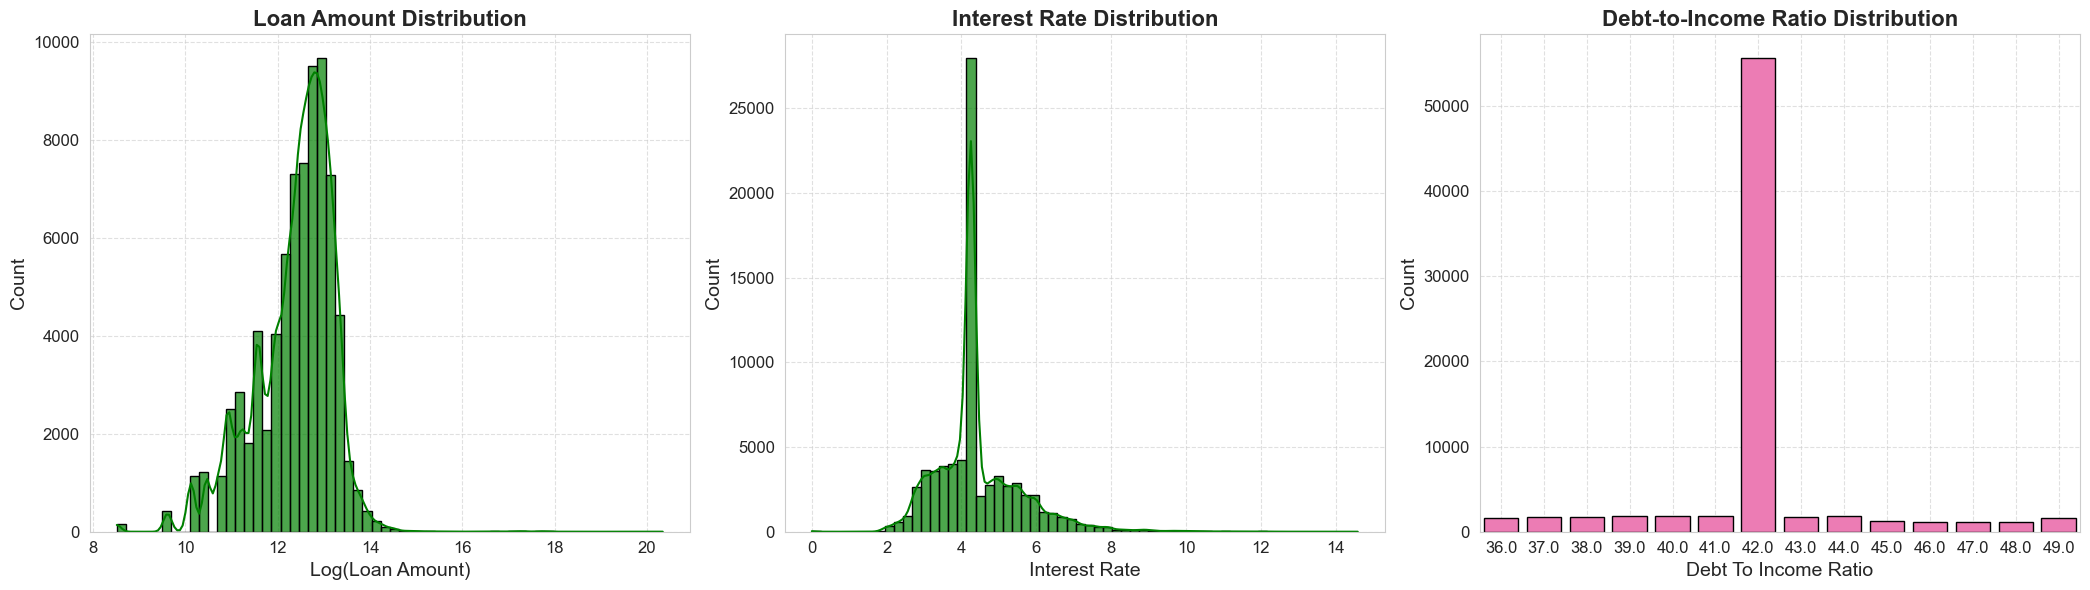

In [15]:
# Set overall style
sns.set_style("whitegrid")

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(21, 6))

# Define key financial features and titles
features = ['loan_amount', 'interest_rate', 'debt_to_income_ratio']
titles = ['Loan Amount Distribution', 'Interest Rate Distribution', 'Debt-to-Income Ratio Distribution']

# Loop through each feature and create improved histograms
for ax, feature, title in zip(axes, features, titles):
    data = HDMA_filtered[feature]

    # Handle extreme skew in 'loan_amount' using log scale for better visualization
    if feature == 'loan_amount':
        data = np.log1p(data)  # Log transformation to spread out large values
        xlabel = "Log(Loan Amount)"
    else:
        xlabel = feature.replace("_", " ").title()

    # Use KDE only for continuous variables
    if feature == "debt_to_income_ratio":
        # Use bar plot for discrete variable
        dti_counts = data.value_counts().sort_index()
        sns.barplot(x=dti_counts.index, y=dti_counts.values, ax=ax, color="hotpink", edgecolor="black")
    else:
        # Histogram + KDE for continuous variables
        sns.histplot(data, bins=60, kde=True, ax=ax, color="green", alpha=0.7, edgecolor="black", linewidth=1, line_kws={"color": "black"})

    # Set titles and labels
    ax.set_title(title, fontsize=16, fontweight="bold")
    ax.set_xlabel(xlabel, fontsize=14)
    ax.set_ylabel("Count", fontsize=14)
    ax.tick_params(axis="both", labelsize=12)

    # Add gridlines for better readability
    ax.grid(True, linestyle="--", alpha=0.6)

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

/Users/dmeyer/Library/Python/3.9/lib/python/site-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/Users/dmeyer/Library/Python/3.9/lib/python/site-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/Users/dmeyer/Library/Python/3.9/lib/python/site-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


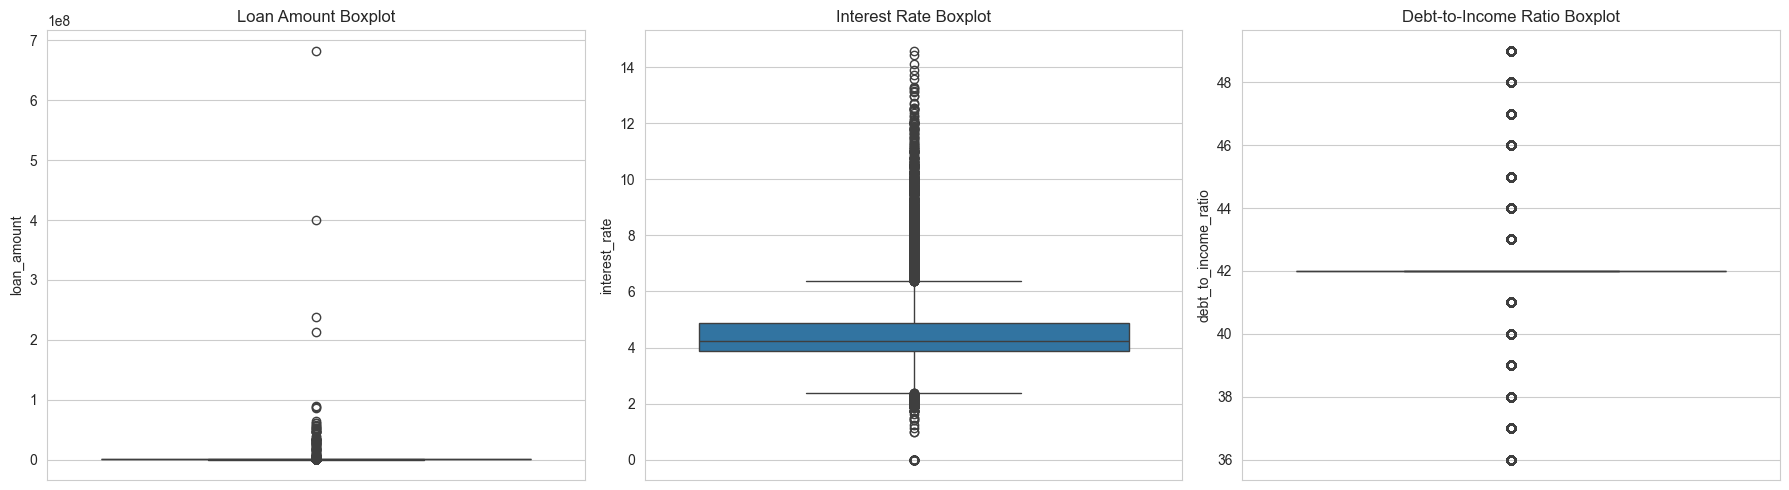

/Users/dmeyer/Library/Python/3.9/lib/python/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/dmeyer/Library/Python/3.9/lib/python/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/dmeyer/Library/Python/3.9/lib/python/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/dmeyer/Library/Python

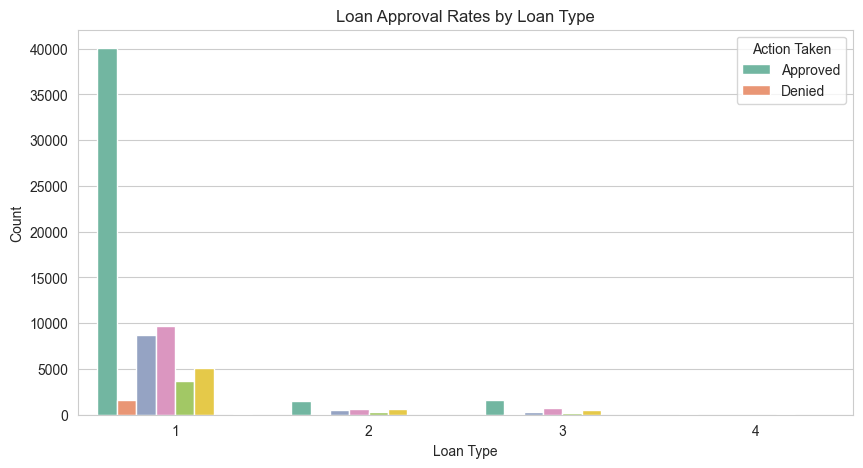

In [16]:
# Boxplots for outlier detection
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.boxplot(y=HDMA_filtered['loan_amount'], ax=axes[0])
axes[0].set_title("Loan Amount Boxplot")

sns.boxplot(y=HDMA_filtered['interest_rate'], ax=axes[1])
axes[1].set_title("Interest Rate Boxplot")

sns.boxplot(y=HDMA_filtered['debt_to_income_ratio'], ax=axes[2])
axes[2].set_title("Debt-to-Income Ratio Boxplot")

plt.tight_layout()
plt.show()

# Loan Approval Rates by Loan Type
plt.figure(figsize=(10, 5))
sns.countplot(data=HDMA_filtered, x="loan_type", hue="action_taken", palette="Set2")
plt.title("Loan Approval Rates by Loan Type")
plt.xlabel("Loan Type")
plt.ylabel("Count")
plt.legend(title="Action Taken", labels=["Approved", "Denied"])
plt.show()

## **Building a random forest**

### 🎯 Target Variable Definition: `loan_approved`

In this analysis, our goal is to detect and mitigate **bias in lender decisions** — not applicant behavior. Therefore, we define our target variable `loan_approved` by focusing only on outcomes where the **lender made an approval or denial decision**.

#### ✅ We consider the following `action_taken` codes as **lender approvals**:
- `1`: Loan originated  
- `2`: Application approved but not accepted  
- `8`: Preapproval request approved but not accepted  

These reflect cases where the **lender said yes**, regardless of whether the applicant accepted the offer.

#### ❌ We consider the following `action_taken` codes as **lender denials**:
- `3`: Application denied  
- `7`: Preapproval request denied  

These represent direct **denial decisions made by the lender**.

#### 🚫 We **exclude** the following outcomes from our analysis:
- `4`: Application withdrawn by applicant (customer’s choice)  
- `5`: File closed for incompleteness (possibly missing documents)  
- `6`: Purchased loan (no approval decision was made)

These cases do not reflect clear lender intent, so including them could distort our fairness analysis.

**I used a different variable name for each step - for easy debugging**

In [17]:
# STEP 1: Make a copy of the filtered HMDA data
rf_model_data_1 = HDMA_filtered.copy()

# STEP 2: Filter dataset to include only lender decisions (remove irrelevant action_taken values)
rf_model_data_2 = rf_model_data_1[rf_model_data_1['action_taken'].isin([1, 2, 3, 7, 8])]

# STEP 3: Define target variable: 1 = approved, 0 = denied
rf_model_data_3 = rf_model_data_2.copy()
rf_model_data_3['loan_approved'] = rf_model_data_3['action_taken'].isin([1, 2, 8]).astype(int)

# Show the first few rows to verify changes
# rf_model_data_3.head()

In [18]:
rf_model_data_3['loan_approved'].value_counts()

loan_approved
1    45070
0     9608
Name: count, dtype: int64

In [19]:
# Step 4: Define the features we want to use for prediction
selected_features = [
    'derived_race', 'derived_ethnicity', 'derived_sex',
    'applicant_age', 'income',
    'loan_amount', 'interest_rate', 'loan_purpose', 'loan_type', 'debt_to_income_ratio'
]

# Step 5: Keep only selected features + target variable
rf_model_data_4 = rf_model_data_3[selected_features + ['loan_approved']].copy()  # 💡 use .copy() to avoid warning

# Step 6: Convert age to string since it's in range format like '35-44'
rf_model_data_4['applicant_age'] = rf_model_data_4['applicant_age'].astype(str)

In [20]:
# Replace numeric codes with descriptions for loan_purpose
rf_model_data_4['loan_purpose'] = rf_model_data_4['loan_purpose'].replace({
    1: 'Home purchase',
    2: 'Home improvement',
    31: 'Refinancing',
    32: 'Cash-out refinancing',
    4: 'Other purpose',
    5: 'Not applicable'
})

# Replace numeric codes with descriptions for loan_type
rf_model_data_4['loan_type'] = rf_model_data_4['loan_type'].replace({
    1: 'Conventional',
    2: 'FHA',
    3: 'VA',
    4: 'RHS or FSA'
})

In [21]:
# Step 7: One-hot encode only the categorical features among selected ones
rf_model_data_5 = pd.get_dummies(
    rf_model_data_4,
    columns=['derived_race', 'derived_ethnicity', 'derived_sex', 'applicant_age', 'loan_purpose', 'loan_type'],
    drop_first=True
)

In [22]:
#rf_model_data_5.head()

In [23]:
# Step 8: Separate features (X) from the target variable (y)
X = rf_model_data_5.drop('loan_approved', axis=1)
y = rf_model_data_5['loan_approved']

In [24]:
# Step 9: Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,          # 20% for testing
    stratify=y,             # preserves the proportion of 1s and 0s in both sets
    random_state=42         # ensures reproducibility
)

In [25]:
# Step 10: Train the Random Forest model on the training set
# Initialize the model with 100 trees
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the model to the training data
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [26]:
# Step 11: Make predictions on the test set
# Use the trained model to predict loan approvals
y_pred = rf_model.predict(X_test)

In [27]:
# Step 12: Evaluate model performance
# Print core evaluation metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))

# Show classification report with F1-score
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Show confusion matrix
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.9693672275054864
Precision: 0.9882975132215596
Recall: 0.9743731972487242

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.95      0.92      1922
           1       0.99      0.97      0.98      9014

    accuracy                           0.97     10936
   macro avg       0.94      0.96      0.95     10936
weighted avg       0.97      0.97      0.97     10936

Confusion Matrix:
 [[1818  104]
 [ 231 8783]]


 ### **Model Evaluation Summary**

After training the Random Forest model to predict whether a home loan will be approved (`loan_approved = 1`) or denied (`loan_approved = 0`), we evaluated it using a test set of **10,936** records. Below is a detailed explanation of the model's performance.

---

### **Overall Accuracy: 96.99%**
Out of all the test samples, **96.99%** of the predictions made by the model were correct.

The model is performing very well overall.

---

###  **Class Breakdown**

#### **Class 0 — Denied Loans**
| Metric     | Value | Interpretation                                                  |
|------------|-------|------------------------------------------------------------------|
| Precision  | 0.89  | When the model predicts a loan is denied, it's correct 89% of the time. |
| Recall     | 0.95  | The model correctly identifies 95% of all denied loans.          |
| F1-Score   | 0.92  | A balanced score combining precision and recall.                |

#### **Class 1 — Approved Loans**
| Metric     | Value | Interpretation                                                   |
|------------|-------|-------------------------------------------------------------------|
| Precision  | 0.99  | When the model predicts a loan is approved, it's correct 99% of the time. |
| Recall     | 0.97  | The model correctly identifies 97% of all approved loans.         |
| F1-Score   | 0.98  | Excellent balance between precision and recall.                   |

---

### **Confusion Matrix Explanation**

|                  | Predicted Denied | Predicted Approved |
|------------------|------------------|---------------------|
| **Actual Denied** (0) | 1825 ✅ (correct) | 97 ❌ (mistakenly approved) |
| **Actual Approved** (1) | 232 ❌ (mistakenly denied) | 8782 ✅ (correct) |

The model:
- Correctly predicted **1825** denied loans
- Incorrectly approved **97** denied loans
- Incorrectly denied **232** approved loans
- Correctly predicted **8782** approved loans

#### **Next, we try to find the features that are important**

/var/folders/2c/syyg1pks1tn35zqcqdf1629m0000gn/T/ipykernel_11458/1512381910.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(15), palette='plasma')
/Users/dmeyer/Library/Python/3.9/lib/python/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/dmeyer/Library/Python/3.9/lib/python/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_gr

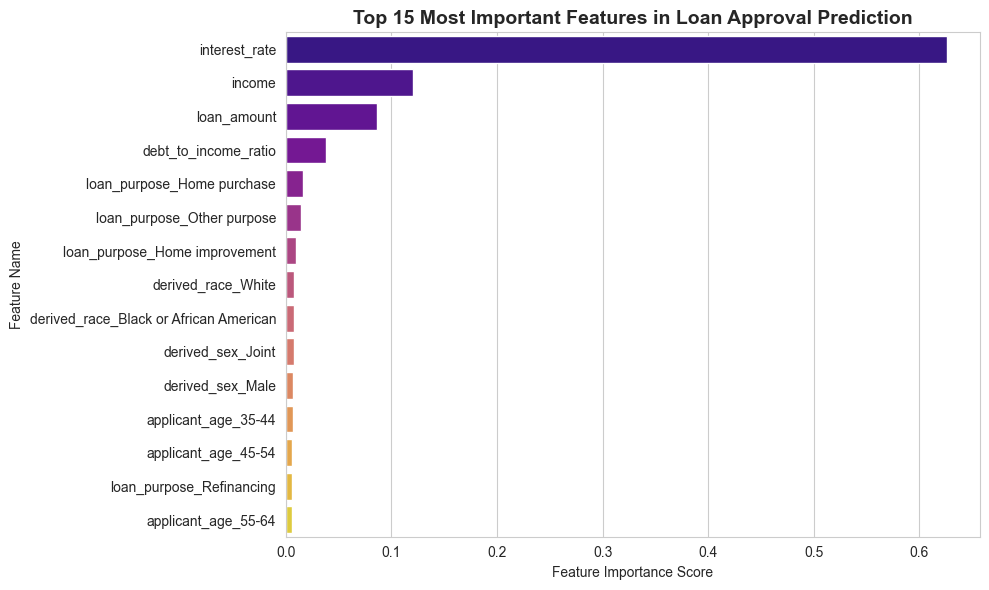

In [28]:
# Step 13: Visualize Feature Importance from the Random Forest model
# Get feature importances and sort them
importances = rf_model.feature_importances_
feature_names = X.columns
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot top 15 most important features
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(15), palette='plasma')
plt.title("Top 15 Most Important Features in Loan Approval Prediction", fontsize=14, weight='bold')
plt.xlabel("Feature Importance Score")
plt.ylabel("Feature Name")
plt.tight_layout()
plt.show()

### **Why Is Interest Rate the Most Important Feature?**

At first, it seems strange that interest rate influences loan approval, since lenders set it.  
However, the model identified strong patterns linking high interest rates with higher denial rates.

This is likely because:
1. **Lenders still have risk limits** – Even with high rates, some applicants are **too risky** to approve.
2. **Regulations restrict extremely high interest loans** – Loans above a certain rate can be flagged as **"high-cost"** and denied.
3. **Affordability thresholds matter** – A high interest rate can push **monthly payments too high**, failing debt-to-income (DTI) requirements.

4. **Interest rate acts as a proxy for credit risk** – Since the dataset does not include FICO scores or credit history, the model may be using interest rate as a **stand-in for the borrower’s financial credibility** and risk level.

### **Other Important Features**

Besides interest rate, the model ranked these features as next most important:

- **Income** – Higher income signals better repayment ability → more likely to be approved.
- **Loan Amount** – Larger loan requests may be riskier → more likely to be denied.
- **Debt-to-Income Ratio** – High DTI = financial strain → lower chance of approval.
- **Loan Purpose: Home Purchase** – Home purchase loans are typically safer → more likely to be approved.



### **Detecting Bias in Loan Approvals**

To evaluate fairness in our model, we begin with a **disparity analysis**:

We compare **loan approval rates** across key demographic groups — including **race**, **ethnicity**, and **sex** — to identify any **inequities** in outcomes.

If certain groups consistently receive **lower approval rates**, this may signal potential **bias** in the data or model, even if unintentional.

This step is essential for ensuring that our model doesn't simply perform well — it also performs **fairly**.

In [29]:
# Use the original data with demographic info
bias_df = rf_model_data_3.copy()

# Calculate approval rates by race, ethnicity, and sex (as percentages)
approval_by_race = (bias_df.groupby('derived_race')['loan_approved'].mean() * 100).sort_values(ascending=False)
approval_by_ethnicity = (bias_df.groupby('derived_ethnicity')['loan_approved'].mean() * 100).sort_values(ascending=False)
approval_by_sex = (bias_df.groupby('derived_sex')['loan_approved'].mean() * 100).sort_values(ascending=False)

# Round to 2 decimal places for cleaner output
approval_by_race = approval_by_race.round(2)
approval_by_ethnicity = approval_by_ethnicity.round(2)
approval_by_sex = approval_by_sex.round(2)

# Display
print("✅ Approval Rate by Race (%):\n", approval_by_race, "\n")
print("✅ Approval Rate by Ethnicity (%):\n", approval_by_ethnicity, "\n")
print("✅ Approval Rate by Sex (%):\n", approval_by_sex)


✅ Approval Rate by Race (%):
 derived_race
Joint                                        88.35
White                                        86.19
Asian                                        83.64
Race Not Available                           78.66
Free Form Text Only                          75.00
Black or African American                    69.70
American Indian or Alaska Native             66.30
2 or more minority races                     65.77
Native Hawaiian or Other Pacific Islander    65.00
Name: loan_approved, dtype: float64 

✅ Approval Rate by Ethnicity (%):
 derived_ethnicity
Joint                      86.13
Not Hispanic or Latino     83.62
Ethnicity Not Available    79.19
Hispanic or Latino         73.43
Free Form Text Only        60.87
Name: loan_approved, dtype: float64 

✅ Approval Rate by Sex (%):
 derived_sex
Joint                88.01
Male                 80.32
Sex Not Available    80.26
Female               77.99
Name: loan_approved, dtype: float64


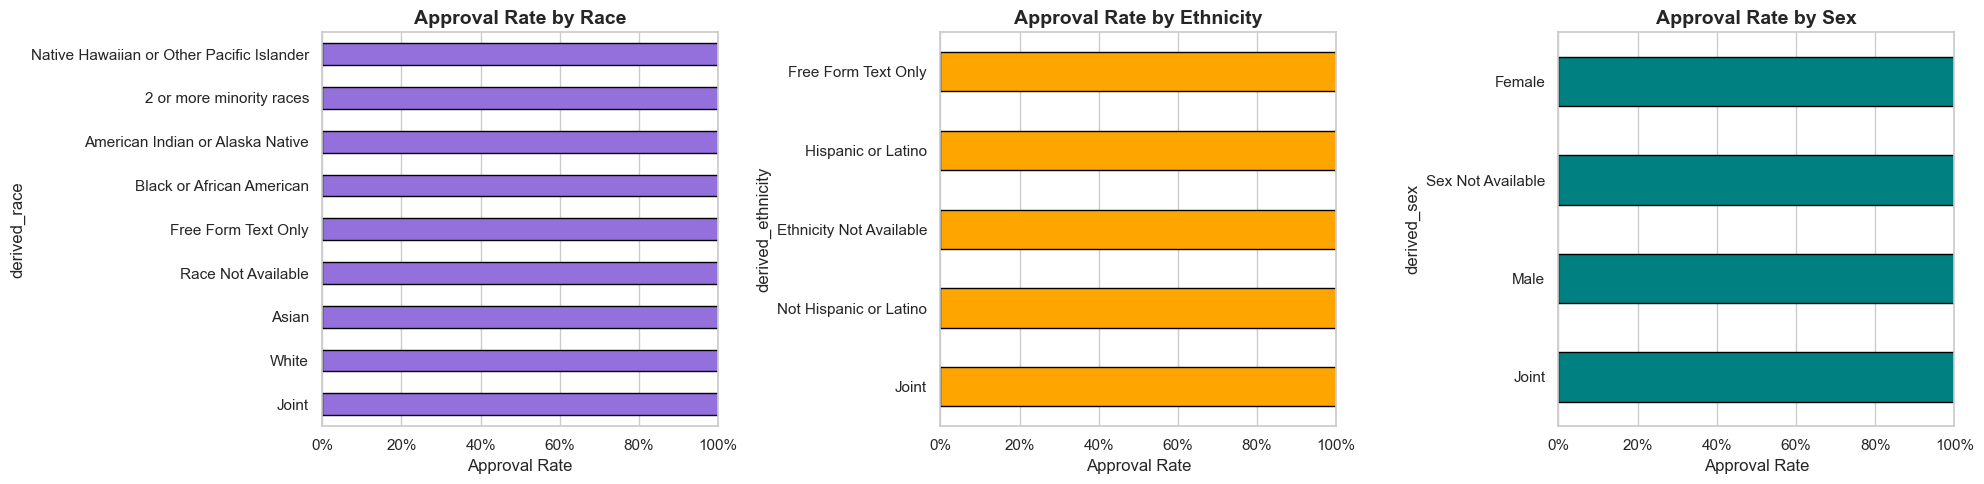

In [30]:
import matplotlib.ticker as mtick  # For percentage formatting

# Set style
sns.set(style="whitegrid")

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

# Plot 1: Race
approval_by_race.plot(kind='barh', ax=axes[0], color='mediumpurple', edgecolor='black')
axes[0].set_title('Approval Rate by Race', fontsize=14, weight='bold')
axes[0].set_xlabel('Approval Rate')
axes[0].xaxis.set_major_formatter(mtick.PercentFormatter(1.0))  # format as percent
axes[0].set_xlim(0, 1)

# Plot 2: Ethnicity
approval_by_ethnicity.plot(kind='barh', ax=axes[1], color='orange', edgecolor='black')
axes[1].set_title('Approval Rate by Ethnicity', fontsize=14, weight='bold')
axes[1].set_xlabel('Approval Rate')
axes[1].xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
axes[1].set_xlim(0, 1)

# Plot 3: Sex
approval_by_sex.plot(kind='barh', ax=axes[2], color='teal', edgecolor='black')
axes[2].set_title('Approval Rate by Sex', fontsize=14, weight='bold')
axes[2].set_xlabel('Approval Rate')
axes[2].xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
axes[2].set_xlim(0, 1)

# Tight layout
plt.tight_layout()
plt.show()

### **Disparity in Loan Approval Rates**

We compared loan approval rates across **race**, **ethnicity**, and **sex** to uncover possible signs of bias.

#### **By Race**:
- **White applicants:** 86.2% approved  
- **Black or African American applicants:** 69.7% approved  
- **Asian applicants:** 83.6% approved  
- **American Indian or Alaska Native:** 66.3% approved  
- **Pacific Islander:** 65.0% approved

**Notable Gap:** Black and Indigenous applicants have **approval rates ~17–20% lower** than White applicants.

---

#### **By Ethnicity:**
- **Not Hispanic or Latino:** 83.6% approved  
- **Hispanic or Latino:** 73.4% approved  
- **Free Form Text Only:** 60.9% approved

**Notable Gap:** Hispanic applicants are approved **10% less often** than Non-Hispanic applicants.

---

#### By Sex:
- **Male:** 80.3% approved  
- **Female:** 77.9% approved  
- **Joint applicants:** 88.0% approved

**Notable Gap:** Female applicants have **slightly lower approval rates** than male applicants.

---

There appear to be consistent/systemic gaps in approval rates across race and ethnicity. While some of this may be due to real financial differences between applicants — such as income, debt levels, or loan amounts — the size and pattern of these gaps suggest that bias in the decision-making process may also be a factor.

## **Building a Logistic Regression (using the train_test_split above)**

In [31]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression


# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train logistic regression
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Model evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.8211411850768106
              precision    recall  f1-score   support

           0       0.13      0.00      0.01      1928
           1       0.82      1.00      0.90      9008

    accuracy                           0.82     10936
   macro avg       0.48      0.50      0.45     10936
weighted avg       0.70      0.82      0.74     10936



## **Building a Logistic Regression**

In [32]:
# Make a copy of the data
logreg_data = HDMA_filtered.copy()

In [33]:
# Check for Missing Values
#print(logreg_data.isnull().sum())

All values are accounted for. Now we need to check the data types

In [34]:
# Check the data types
# print(logreg_data.dtypes)

We have several different data types. Logistic regression requires numerical inputs. We will need to useing label encoding, ordinal encoding, and one hot encoding

In [35]:
from sklearn.preprocessing import LabelEncoder

label_enc = LabelEncoder()
logreg_data['derived_sex'] = label_enc.fit_transform(logreg_data['derived_sex'])
logreg_data['derived_ethnicity'] = label_enc.fit_transform(logreg_data['derived_ethnicity'])


In [36]:
from sklearn.preprocessing import OrdinalEncoder

# Map numeric values back to age categories
age_mapping = {
    0.0: '<25',
    1.0: '25-34',
    2.0: '35-44',
    3.0: '45-54',
    4.0: '55-64',
    5.0: '65-74',
    6.0: '>74'
}

logreg_data['applicant_age'] = logreg_data['applicant_age'].map(age_mapping)

# Handle missing values
logreg_data['applicant_age'].fillna('Unknown', inplace=True)  # Option 1: Replace NaNs with 'Unknown'
# logreg_data.dropna(subset=['applicant_age'], inplace=True)  # Option 2: Drop rows with NaNs

# Apply Ordinal Encoding
age_order = [['<25', '25-34', '35-44', '45-54', '55-64', '65-74', '>74', 'Unknown']]
ord_enc = OrdinalEncoder(categories=age_order)

logreg_data[['applicant_age']] = ord_enc.fit_transform(logreg_data[['applicant_age']])


/var/folders/2c/syyg1pks1tn35zqcqdf1629m0000gn/T/ipykernel_11458/2212387245.py:17: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  logreg_data['applicant_age'].fillna('Unknown', inplace=True)  # Option 1: Replace NaNs with 'Unknown'


In [37]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(drop='first', sparse_output=False)  # Drop first category to prevent redundancy

categorical_cols = ['loan_type', 'loan_purpose', 'lien_status']  # Choose only key features
encoded_cols = encoder.fit_transform(logreg_data[categorical_cols])

logreg_data = logreg_data.drop(columns=categorical_cols)  # Drop original categorical columns
logreg_data[encoder.get_feature_names_out(categorical_cols)] = encoded_cols  # Add back encoded data


In [38]:
# When I was running the code, for some reason the lei was creating hundreds of rows.
# Dont think it is essential so just removed it.

logreg_data = logreg_data.loc[:, ~logreg_data.columns.str.startswith('lei')]

In [39]:
logreg_data = pd.get_dummies(logreg_data,
                             columns=['derived_race', 'conforming_loan_limit',
                                      'derived_loan_product_type', 'derived_dwelling_category'],
                             drop_first=True)

In [ ]:
#print(np.isinf(logreg_data).sum())
#print((logreg_data > 1e10).sum())

In [40]:
# For some reason census_tract has a lot of missing values, so we are going to remove that
logreg_data = logreg_data.drop(columns=['census_tract'])

In [41]:
# Define lender approval (1) and denial (0) cases
approved_codes = {1, 2, 8}
denied_codes = {3, 7}

# Filter dataset to only include lender decisions
filtered_data = logreg_data[logreg_data['action_taken'].isin(approved_codes | denied_codes)].copy()

# Create target variable (loan_approved)
filtered_data['loan_approved'] = filtered_data['action_taken'].apply(lambda x: 1 if x in approved_codes else 0)

# Drop original action_taken column
filtered_data.drop(columns=['action_taken'], inplace=True)

X_lr = filtered_data.drop(columns=['loan_approved'])  # Features
y_lr = filtered_data['loan_approved']  # Target


In [42]:
from sklearn.model_selection import train_test_split

X_train_lr, X_test_lr, y_train_lr, y_test_lr = train_test_split(X_lr, y_lr, test_size=0.2, random_state=42)

In [43]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(max_iter=5000, solver='lbfgs')
logreg.fit(X_train_lr, y_train_lr)

LogisticRegression(max_iter=5000)

In [44]:
from sklearn.metrics import accuracy_score

y_pred_lr = logreg.predict(X_test_lr)
accuracy = accuracy_score(y_test_lr, y_pred_lr)
print(f'Accuracy: {accuracy:.4f}')

Accuracy: 0.9559


In [45]:
X_lr

,derived_ethnicity,derived_sex,applicant_age,income,debt_to_income_ratio,applicant_race-1,co-applicant_race-1,applicant_ethnicity-1,co-applicant_ethnicity-1,loan_amount,...,conforming_loan_limit_NC,derived_loan_product_type_Conventional:Subordinate Lien,derived_loan_product_type_FHA:First Lien,derived_loan_product_type_FHA:Subordinate Lien,derived_loan_product_type_FSA/RHS:First Lien,derived_loan_product_type_FSA/RHS:Subordinate Lien,derived_loan_product_type_VA:First Lien,derived_dwelling_category_Multifamily:Site-Built,derived_dwelling_category_Single Family (1-4 Units):Manufactured,derived_dwelling_category_Single Family (1-4 Units):Site-Built
0,0,3,7.0,81.0,49.0,6.0,8.0,3.0,5.0,445000.0,...,False,False,False,False,False,False,False,False,False,True
1,4,0,7.0,94.0,40.0,3.0,8.0,2.0,5.0,255000.0,...,False,False,False,False,False,False,False,False,False,True
2,4,1,7.0,204.0,42.0,2.0,2.0,2.0,2.0,275000.0,...,False,False,False,False,False,False,False,False,False,True
3,2,2,7.0,195.0,42.0,5.0,8.0,1.0,5.0,55000.0,...,False,True,False,False,False,False,False,False,False,True
4,0,3,7.0,109.0,42.0,6.0,8.0,3.0,5.0,235000.0,...,False,False,True,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76106,0,1,7.0,145.0,42.0,6.0,6.0,3.0,3.0,255000.0,...,False,False,False,False,False,False,False,False,False,True
76107,4,2,7.0,237.0,42.0,5.0,5.0,2.0,2.0,405000.0,...,False,False,False,False,False,False,False,False,False,True
76108,0,3,7.0,95.0,39.0,6.0,8.0,3.0,5.0,315000.0,...,False,False,True,False,False,False,False,False,False,True
76109,0,3,7.0,138.0,42.0,6.0,6.0,3.0,3.0,385000.0,...,False,False,False,False,False,False,False,False,False,True


In [46]:
y_lr[:1000]

0       1
1       1
2       1
3       1
4       1
       ..
1482    1
1483    1
1484    1
1485    0
1486    0
Name: loan_approved, Length: 1000, dtype: int64